## Problem description
Forex is the market for trading currency pairs, it is similar to the stock market, but only for a currency pair. In order to trade in the market a chart which contains the historic price and a set of technical indicators (features) is used by the trader to predict the future price. The type of the technical indicators used and the length of the inspection window is up to the trader himself and based on his previous experience. **The end goal is to build a machine learning model to predict the market movements.**
![Forex Chart example](pics\chart_example.png)

## Target of this project 
- benchmark performance of **optimal** neural nets using Autodesigner
- test and compare performance for different sets of features (technical indicators) and time-windows
- come up with a proposal for the set of features to be used in next stage of modeling
- have a baseline performance which is the minimum acceptance criteria moving forward

In [12]:
# code imports
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from auto_design.utils import design
from forex.data.utils import fetch_data
from forex.processing.utils import data_construct

Load the data for EUR/USD pair with the following configurations:
- granularity = 5 minutes
- count = 1000 candles

[fetch_data](.\forex\data\utils.py)

In [2]:
data = fetch_data(granularity='M5', count=1000, instrument='EUR_USD', return_list=False)

In [3]:
data.head()

,time,completed,volume,o,h,l,c
0,2019-11-05T13:00:00.000000000Z,True,74,1.11095,1.11114,1.11091,1.11111
1,2019-11-05T13:05:00.000000000Z,True,53,1.11109,1.11112,1.11086,1.11086
2,2019-11-05T13:10:00.000000000Z,True,58,1.11083,1.11106,1.11083,1.11092
3,2019-11-05T13:15:00.000000000Z,True,72,1.11090,1.11102,1.11066,1.11071
4,2019-11-05T13:20:00.000000000Z,True,149,1.11069,1.11069,1.11002,1.11030


Construct the train and targets matrices by
- Framing the data into **predict window** and **prediction window** and then keep sliding over the data
- Construct features for each window in a way to overcome the **dimension hopping** problem
- **Dimensionality reduction** into the most meaningful features, hence deacreasing the data points requirements

![Window chart example](pics\window.png)
[data_construct](.\forex\processing\utils.py)

In [4]:
# construct supervised learning data
output = data_construct(DataFrame=data, lookUp=10, predictionWindow=5, pairName='EUR/USD')
f_map = output['mappingDict']
raw_inputs = output['rawInputs']
x = output['inputFeatures']
y = output['targets']

print('Shape of features matrix: {} examples and {} features'.format(x.shape[0], x.shape[1]))
print('Shape of targets matrix: {} examples and {} target'.format(y.shape[0], y.shape[1]))

Shape of features matrix: 953 examples and 62 features
Shape of targets matrix: 953 examples and 1 target


Construct the four competing datasets for training aand evaluation
- dataset one: sma features
- dataset two: ema features
- dataset three: band features
- dataset four: macd features

In [5]:
# construct sma features
x_sma = x[:, [f_map['sma_latest_crossover'],
              f_map['sma_location_of_latest_crossover'],
              f_map['sma_latest_crossover_angle'],
              f_map['sma_dominant_type_fast_slow']]]
print('Shape of x_sma matrix: {} examples and {} features'.format(x_sma.shape[0], x_sma.shape[1]))

# construct ema features
x_ema = x[:, [f_map['ema_latest_crossover'],
              f_map['ema_location_of_latest_crossover'],
              f_map['ema_latest_crossover_angle'],
              f_map['ema_dominant_type_fast_slow']]]
print('Shape of x_ema matrix: {} examples and {} features'.format(x_ema.shape[0], x_ema.shape[1]))

# construct band features
x_band = x[:, [f_map['deltaBands_mean'],
               f_map['deltaBands_std'],
               f_map['deltaBands_maximum_mean'],
               f_map['deltaBands_maximum_location'],
               f_map['deltaBands_minimum_mean'],
               f_map['deltaBands_minimum_location']]]
print('Shape of x_band matrix: {} examples and {} features'.format(x_band.shape[0], x_band.shape[1]))

# construct macd features
x_macd = x[:, [f_map['macd_latest_crossover'],
               f_map['macd_location_of_latest_crossover'],
               f_map['macd_latest_crossover_angle'],
               f_map['macd_dominant_type_fast_slow']]]
print('Shape of x_macd matrix: {} examples and {} features'.format(x_macd.shape[0], x_macd.shape[1]))

Shape of x_sma matrix: 953 examples and 4 features
Shape of x_ema matrix: 953 examples and 4 features
Shape of x_band matrix: 953 examples and 6 features
Shape of x_macd matrix: 953 examples and 4 features


Design and train the optimal ML pipeline for each features subset and compare performance
- [design (entry point)](.\auto_design\utils.py)
- [process (data pre processing)](.\auto_design\pre_processing\process.py)
- [feature eng. (encoder)](.\auto_design\feature_engineering\encoder.py)
- [modeling (constructing ML model)](.\auto_design\modeling\neural_nets.py)
- [optimizer (genetic algos)](.\auto_design\optimizer\genetic.py)

![flowchart](pics\auto_desing_flow.png)

In [6]:
# specify problem type
problem_type = 'regression'
# specify the size of population and number of generations
size_population = 10
number_generations = 10

warnings.filterwarnings('ignore')

In [7]:
# sma features
model_sma, log_sma = design(x_sma, y, problem_type, size_population, number_generations)
sma_error = min([i['min'] for i in log_sma])

W1111 02:30:18.286625  1640 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1111 02:30:18.310423  1640 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1111 02:30:18.314800  1640 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1111 02:30:18.444093  1640 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1111 02:30:18.739411  1640 deprecation_wrapper.py:119] From C:\ProgramData\Anac

95/95 [==============================] - 0s 21us/step
gen	nevals	avg    	min    	max    
0  	3     	6.02565	5.96804	6.06108
1  	0     	5.99464	5.96804	6.04785
95/95 [==============================] - 0s 21us/step
2  	2     	5.92492	5.89813	5.96804


In [8]:
# ema features
model_ema, log_ema = design(x_ema, y, problem_type, size_population, number_generations)
ema_error = min([i['min'] for i in log_ema])

95/95 [==============================] - 0s 34us/step
gen	nevals	avg    	min    	max    
0  	3     	5.73193	5.63532	5.92508
95/95 [==============================] - 0s 26us/step
1  	1     	5.68415	5.63532	5.78181
95/95 [==============================] - 0s 30us/step
2  	2     	5.65699	5.63532	5.69693


In [9]:
# band features
model_band, log_band = design(x_band, y, problem_type, size_population, number_generations)
band_error = min([i['min'] for i in log_band])

95/95 [==============================] - 0s 31us/step
gen	nevals	avg    	min    	max    
0  	3     	9.74902	9.63324	9.92101
95/95 [==============================] - 0s 48us/step
1  	1     	9.65388	9.63324	9.69517
2  	0     	9.63324	9.63324	9.63324


In [10]:
# construct macd features
model_macd, log_macd = design(x_macd, y, problem_type, size_population, number_generations)
macd_error = min([i['min'] for i in log_macd])

95/95 [==============================] - 0s 63us/step
gen	nevals	avg    	min    	max    
0  	3     	6.67935	6.59437	6.84112
95/95 [==============================] - 0s 56us/step
1  	3     	6.65427	6.59168	6.73399
95/95 [==============================] - 0s 72us/step
2  	2     	6.60117	6.5903 	6.62154


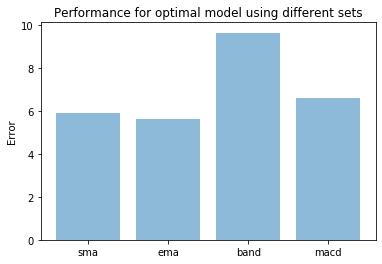

In [11]:
# visualize the results of the experiment
objects = ('sma', 'ema', 'band', 'macd')
y_pos = np.arange(len(objects))
performance = [sma_error, ema_error, band_error, macd_error]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Error')
plt.title('Performance for optimal model using different sets')

plt.show()